# Retrieval 4: Using parameter functions

:::{admonition} About this retrieval example
This example shows how to use the [rt1 python package](https://github.com/raphaelquast/rt1_model) together with [scipy optimize](https://docs.scipy.org/doc/scipy/reference/optimize.html) to setup a retrieval procedure to:

- obtain static and dynamic parameters from a series of incidence-angle dependent $\sigma^0$ measurements.
- use functions to represent model parameters
:::

In [10]:
%matplotlib widget
from rt1_model import RT1, surface, volume, set_loglevel
from scipy.optimize import least_squares
import matplotlib.pyplot as plt
import numpy as np

rand = np.random.RandomState(123456)  # initialize a reproducible random state
set_loglevel("info")

## Specify simulation and fit parameters
### Set parameter values that are used to simulate the data

In [11]:
dB, sig0 = False, True

num = 100  # Number of measurements
incs = 30  # Available incidence angles per measurement
noise_sigma = 0.5 if dB is True else 1e-3  # Noise-level (sigma of gaussian noise)

inc = rand.normal(45, 10, (num, incs)).clip(20, 70)        # Incidence angles
N = rand.normal(0.1, 0.1, (num, 1)).clip(0.01, 0.25)       # NormBRDF values

phi = np.linspace(0, 2.* np.pi, num)[:,np.newaxis]
dphi = rand.randint(0, 200)/100

sim_params = dict(k=2.5, dphi=dphi, omega=0.2, N=N)  # Simulation parameter values
const_params = dict(t_s=0.4, phi=phi, PI=np.pi)      # Constant parameters (assumed to be known)

### Set start values and boundaries for the fit

In [12]:
start_vals = dict(omega=[0.1], k=[1], N=[0.1]*num, dphi=[1])
bnd_vals = dict(omega=[(0.01, 0.5)], k=[(0.5, 5.)], N=[(0.01, 0.5)]*num, dphi=[(0., np.pi)])

## Setup RT1 and create a simulated dataset

In [13]:
V = volume.Rayleigh()
SRF = surface.HG_nadirnorm(t="t_s", ncoefs=10)

R = RT1(V=V, SRF=SRF, int_Q=True, dB=dB, sig0=sig0)
R.set_monostatic(p_0=0)
R.NormBRDF = "N/3 + 5*N**2"
R.tau = "k * (phi + dphi) / (6*PI) * sin(phi + dphi)**(2)"

R.set_geometry(t_0=np.deg2rad(inc))
tot = R.calc(**sim_params, **const_params)[0]
tot += rand.normal(0, noise_sigma, tot.shape)  # Add some random noise

18:17:47.073 INFO: Evaluating coefficients for interaction-term...
18:17:47.184 INFO: Coefficients extracted, it took 0.02795 sec.


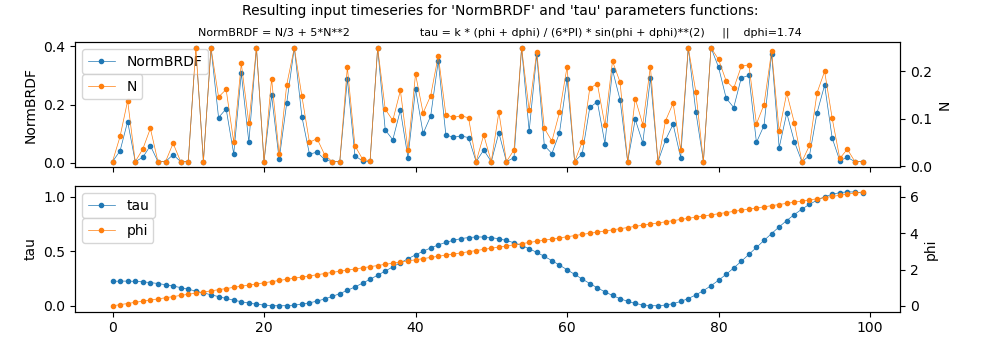

In [14]:
f, (ax, ax2) = plt.subplots(2, figsize=(10, 3.5), sharex=True, gridspec_kw=dict(hspace=0.15))
f.canvas.header_visible = False
f.text(0.5, .99, "Resulting input timeseries for 'NormBRDF' and 'tau' parameters functions:", ha="center", va="top")
f.text(.5, .92, f"NormBRDF = {R._NormBRDF}                    tau = {R._tau}     ||    dphi={dphi}", ha="center", va="top", fontsize=8)

ax.plot(R.NormBRDF, marker=".", lw=0.5, label="NormBRDF")
ax.set_ylabel("NormBRDF")
ax.legend(loc="upper left")

ax_t = ax.twinx()
ax_t.plot(N, marker=".", lw=0.5, label="N", c="C1")
ax_t.set_xlabel("# measurement")
ax_t.set_ylabel("N")
ax_t.legend(loc="upper left", bbox_to_anchor=(0, .8))

ax2.plot(R.tau, marker=".", lw=0.5, label="tau")
ax2.set_ylabel("tau")
ax2.legend(loc="upper left")

ax2_t = ax2.twinx()
ax2_t.plot(phi, marker=".", lw=0.5, label="phi", c="C1")

ax2_t.set_ylabel("phi")
ax2_t.legend(loc="upper left", bbox_to_anchor=(0, .8))
f.subplots_adjust(left=0.075, right=0.9)


## Setup scipy optimize to fit RT1 model to the data

In [15]:
def parse_params(x):
    """Map 1D parameter array to dict {parameter_name: value(s)}."""
    return dict(omega=x[0], k=x[1], dphi=x[2], N=x[3:][:, np.newaxis])

def fun(x, **kwargs):
    """Calculate residuals."""
    R.update_params(**parse_params(x), **kwargs)
    res = (R.calc()[0] - tot).ravel() # Ravel output because scipy requires 1D arrays
    return res

def jac(x, **kwargs):
    """Calculate jacobian."""
    R.update_params(**parse_params(x), **kwargs)
    jac = R.jacobian(param_list=["omega", "k", "dphi", "N"], format="scipy_least_squares")
    return jac


# Unpack start-values and boundaries as required by scipy optimize
x0 = [*start_vals["omega"], *start_vals["k"], *start_vals["dphi"], *start_vals["N"]]
bounds = list(zip(*[*bnd_vals["omega"], *bnd_vals["k"], *bnd_vals["dphi"], *bnd_vals["N"]]))

res = least_squares(
    fun=fun,
    x0=x0,
    bounds=bounds,
    jac=jac,
    #x_scale="jac",
    ftol=1e-5,
    gtol=1e-5,
    xtol=1e-5,
    verbose=2,
    kwargs=const_params,   # pass constant parameters to "fun" and "jac"
)

# Unpack found parameters
found_params = parse_params(res.x)
# Calcuate total backscatter based on found parameters
found_tot = R.calc(**found_params, **const_params)[0]

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.8725e+01                                    9.91e+00    
       1              2         9.8003e-01      1.77e+01       7.67e-01       1.85e+00    
       2              4         6.9148e-01      2.89e-01       1.49e-01       2.47e+00    
       3              5         6.5098e-01      4.05e-02       3.15e-01       2.52e+00    
       4              6         3.5180e-01      2.99e-01       6.00e-02       1.77e+00    
       5              7         1.8636e-01      1.65e-01       1.34e-01       9.68e-01    
       6              8         8.1120e-02      1.05e-01       8.61e-02       3.66e-01    
       7              9         3.0622e-02      5.05e-02       9.21e-02       1.61e-01    
       8             11         2.9938e-02      6.84e-04       1.12e-01       2.34e-01    
       9             12         2.0934e-02      9.00e-03       1.98e-02       4.64e-02    

In [16]:
from IPython.display import HTML, display
s = ["<table>",
     "<caption>Retrieved Parameters</caption>",
     "<tr><th>Parameter</th><th>Target value</th><th>Start value</th><th>Retrieved value</th><th>(Target - Retrieved)</th></tr>",
     *(f"<tr><td>{key if isinstance(val, (int, float, np.number)) else key + ' <b>(mean)</b>'} </td>"
       f"<td> {np.mean(sim_params[key]):.3f} </td>"
       f"<td>{np.mean(start_vals[key]): .3f}</td>" 
       f"<td> {np.mean(val):.3f}</td>"
       f"<td>{np.mean(val - sim_params[key]): .3f}</td></tr>" 
       for key, val in found_params.items()),
     "</table>"]
display(HTML("\n".join(s)))

Parameter,Target value,Start value,Retrieved value,(Target - Retrieved)
omega,0.200,0.100,0.200,-0.000
k,2.500,1.000,2.505,0.005
dphi,1.740,1.000,1.741,0.001
N (mean),0.108,0.100,0.108,0.000


## Visualize Results
### Plot timeseries

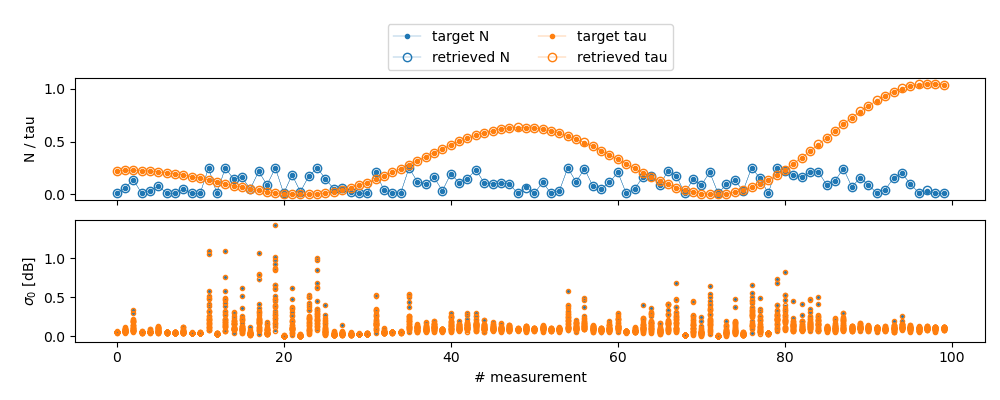

In [17]:
f, (ax, ax2) = plt.subplots(2, figsize=(10, 4), sharex=True)
f.canvas.header_visible = False

# Plot retrieved parameter timeseries
ax.set_ylabel("N / tau")

ax.plot(sim_params["N"], marker=".", lw=0.25, label="target N", c="C0")
ax.plot(found_params["N"], marker="o", lw=0.25, markerfacecolor="none", label="retrieved N", c="C0")

R.update_params(**sim_params, **const_params)
ax.plot(R.tau, marker=".", lw=0.25, label="target tau", c="C1")
R.update_params(**found_params, **const_params)
ax.plot(R.tau, marker="o", lw=0.25, markerfacecolor="none", label="retrieved tau", c="C1")

# Plot backscatter timeseries
ax2.set_ylabel(r"$\sigma_0$ [dB]")
ax2.set_xlabel("# measurement")

ax2.plot(tot, lw=0, marker=".", c="C0", ms=3)
ax2.plot(found_tot, lw=0, marker="o", markerfacecolor="none", c="C1", ms=3)

ax.legend(loc="upper center", ncols=2, bbox_to_anchor=(0.5, 1.5))
f.tight_layout()

### Initialize analyzer widget and overlay results

18:17:52.575 INFO: Evaluating coefficients for interaction-term...
18:17:52.647 INFO: Coefficients extracted, it took 0.01893 sec.


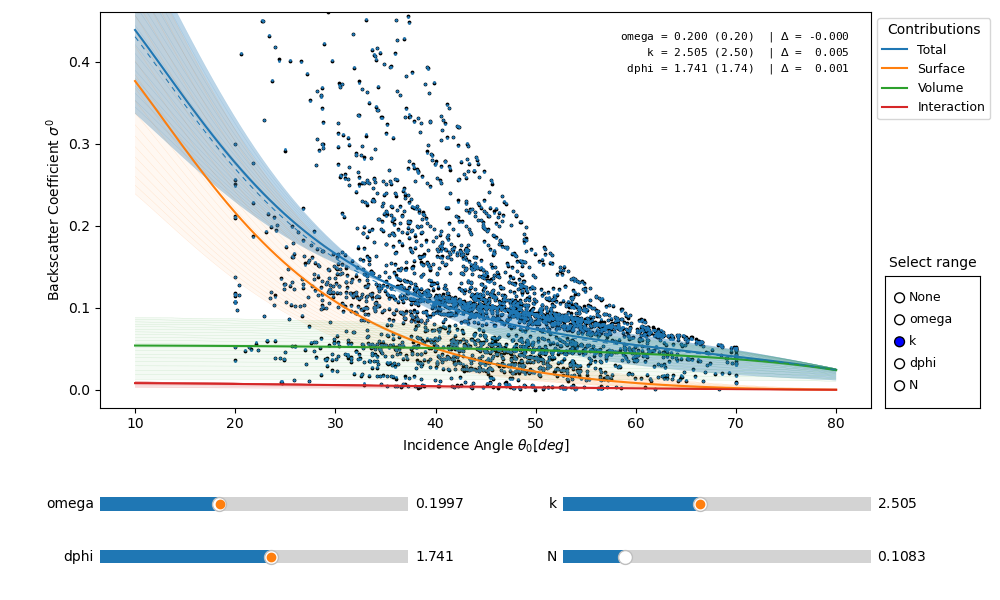

In [18]:
analyze_params = {key: (*np.mean(np.atleast_2d(bnd_vals[key]), axis=0), found_params[key].mean()) for key in found_params}
# pick the measurement for which you want to analyze the components
R.update_params(phi=0)

ana = R.analyze(**analyze_params, range_parameter="k")

# Plot fit-data on top
ana.ax.scatter(inc, tot, c="k", s=3, zorder=0)
ana.ax.scatter(inc, found_tot, c="C0", s=1, zorder=0)

# Indicate fit-results in slider-axes
for key, s in ana.sliders.items():
    if key in ["omega", "k", "dphi"]:
        s.ax.plot(sim_params[key], np.mean(s.ax.get_ylim()), marker="o")

# Add text for static parameters
t = ana.f.text(
    0.6,
    0.95,
    "\n".join(
        [
            f"{key:>8} = {found_params[key]:.3f} ({sim_params[key]:.2f})  "
            rf"| $\Delta$ = {found_params[key] - sim_params[key]: .3f}"
            for key in ["omega", "k", "dphi"]
        ]
    ),
    va="top",
    fontdict=dict(family="monospace", size=8),
)